In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from datetime import date
import requests
import bs4 as bs

In [2]:
import plotly.express as px

In [3]:
###get the list of constituents from wikipedia and make the list####

In [5]:
resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')

In [6]:
table = soup.find('table', {'class':'wikitable sortable'})

In [7]:
ticker = []
ticker_name = []

In [8]:
for row in table.findAll('tr')[1:]:
    name = row.findAll('td')[0].text
    code = row.findAll('td')[1].text
    ticker_name.append(name)
    ticker.append(code)

In [9]:
ticker_name = [s.replace('\n','') for s in ticker_name]

In [10]:
NameAndTicker =pd.DataFrame({'Ticker': ticker,
                           'Name': ticker_name})

In [11]:
NameAndTicker['TickerName'] = NameAndTicker['Ticker']+', '+NameAndTicker['Name']

In [12]:
NameAndTicker.set_index('Ticker',inplace=True)

In [13]:
###getting the stock prices###

In [ ]:
def GetPrices(stocks,period=date(2018,1,1)):
    PricesDaily=DataReader(stocks,"yahoo",period)
    PricesDaily=PricesDaily['Adj Close']
    return PricesDaily

In [ ]:
#ClosePrice = GetPrices(tickers) 
#TickersAllNan = ClosePrice.columns[ClosePrice.isna().all()].to_list() 
###names with all nan
#ClosePrice.drop(columns=TickersAllNan, inplace=True)

In [14]:
##previously pulled data from above code and saved as csv
ClosePrice = pd.read_csv('S&P400MidCap.csv', index_col='Date', parse_dates=True)

In [25]:
mapping = dict(zip(NameAndTicker.index,NameAndTicker['TickerName']))

In [29]:
ClosePrice.columns = ClosePrice.columns.map(mapping)

In [31]:
PriceReturns = ((ClosePrice/ClosePrice.shift(1)) - 1).dropna(how='all')*100

In [32]:
cum_returns = ClosePrice/ClosePrice.fillna(method='bfill').iloc[0,:]

In [33]:
MeanReturns = pd.DataFrame(PriceReturns.mean()*100, columns =['Mean Return'])

In [34]:
total_cum_ret = cum_returns.iloc[-1,:]
annual_return = np.power(total_cum_ret, 250/len(cum_returns))-1

<AxesSubplot:xlabel='Date'>

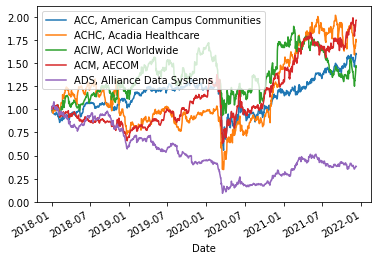

In [35]:
cum_returns.iloc[:,:5].plot()

In [36]:
annual_return = pd.DataFrame(annual_return.values*100, columns = ['Annual Return'], index= annual_return.index).dropna()

In [37]:
Sorted_annual_ret = annual_return.sort_values(by='Annual Return', ascending=False)

<AxesSubplot:title={'center':'Highest 10 Annual Returns'}>

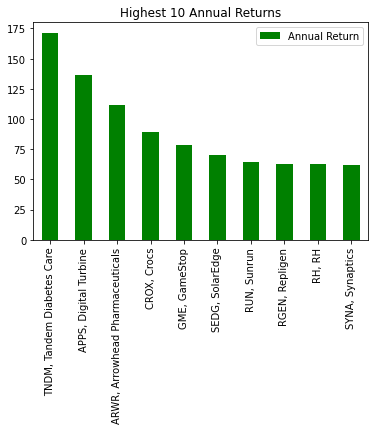

In [39]:
Sorted_annual_ret.iloc[:10].plot.bar(title='Highest 10 Annual Returns', color='green')

<AxesSubplot:title={'center':'Lowest 10 Annual Returns'}>

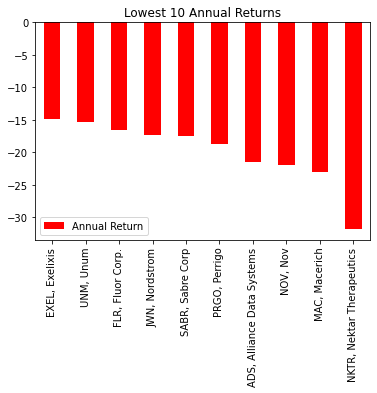

In [40]:
Sorted_annual_ret.iloc[-10:].plot.bar(title='Lowest 10 Annual Returns', color='red')

In [41]:
annual_return.isna().value_counts() ###check NaN values

Annual Return
False            395
dtype: int64

In [42]:
vol_annual = pd.DataFrame(PriceReturns.std().dropna()*16, columns =['Annual Vol'])

Which stocks had highest Vol?

In [44]:
Sorted_Vol = vol_annual.sort_values(by='Annual Vol', ascending=False)

<AxesSubplot:title={'center':'Highest 10 Vol Stocks'}>

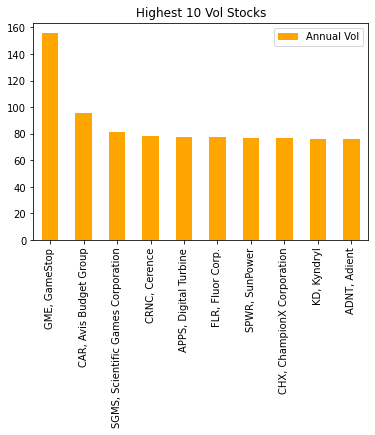

In [47]:
Sorted_Vol.iloc[:10].plot.bar(title='Highest 10 Vol Stocks', color='orange')

<AxesSubplot:title={'center':'Lowest 10 Vol Stocks'}>

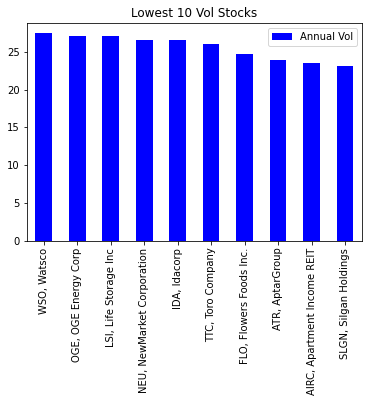

In [48]:
Sorted_Vol.iloc[-10:].plot.bar(title='Lowest 10 Vol Stocks', color='blue')

How was the price performance of the top 10 High and Low Vol stocks?

In [52]:
high_vol_stocks = list(Sorted_Vol.iloc[:10].index)
low_vol_stocks = list(Sorted_Vol.iloc[-10:].index)

In [64]:
def eq_wgt_portfolio_return(stocklist, returns):
    weights = pd.Series(1/len(stocklist), index=stocklist)
    rets = returns.loc[returns.index.isin(stocklist)].squeeze()
    return weights.T @ rets

In [79]:
def eq_wgt_portfolio_vol(stocklist, returns):
    weights = pd.Series(1/len(stocklist), index=stocklist)
    covmat = returns[stocklist].cov()
    vol = (weights.T @ covmat @ weights)**0.5
    return vol

In [65]:
eq_wgt_portfolio_return(high_vol_stocks,annual_return)

29.51517352271957

In [74]:
eq_wgt_portfolio_return(low_vol_stocks,annual_return)

11.673576117406402

In [83]:
eq_wgt_portfolio_vol(high_vol_stocks,PriceReturns)*np.sqrt(252)

48.2382811810902

In [84]:
eq_wgt_portfolio_vol(low_vol_stocks,PriceReturns)*np.sqrt(252)

16.9008354089593

Risk Contribution of an EW portfolio

In [110]:
def eq_wgt_risk_contribution(stocklist, returns):
    covariance = returns[stocklist].cov()
    weights = pd.Series(1/covariance.shape[0], index=covariance.columns)
    portfolio_vol = (weights.T @ covariance @ weights) ** 0.5
    total_portfolio_variance = portfolio_vol ** 2
    marginal_contribution = covariance @ weights
    risk_contribution = np.multiply(marginal_contribution, weights.T)/total_portfolio_variance
    return risk_contribution

<AxesSubplot:>

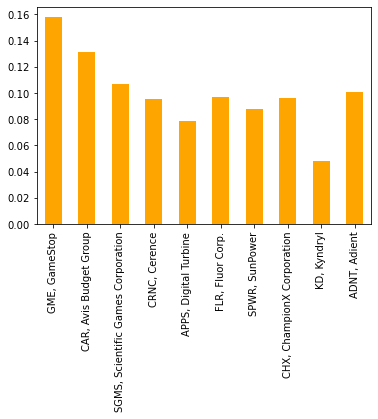

In [113]:
eq_wgt_risk_contribution(high_vol_stocks,PriceReturns).plot.bar(color='orange')

<AxesSubplot:>

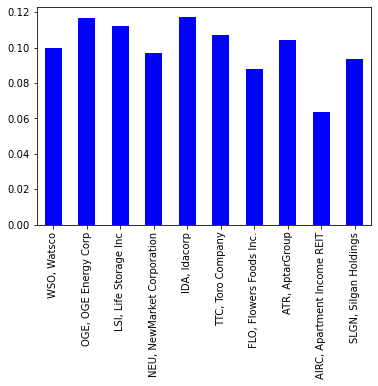

In [114]:
eq_wgt_risk_contribution(low_vol_stocks,PriceReturns).plot.bar(color='blue')

<AxesSubplot:xlabel='Date'>

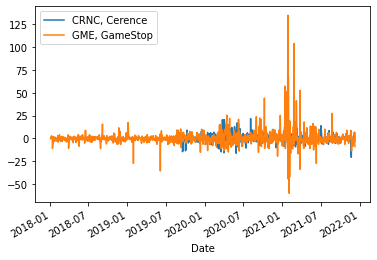

In [106]:
PriceReturns[['CRNC, Cerence','GME, GameStop']].plot()